# 🛡️ Fraud Detection Assignment - A Riskified Analysis

### Submitted by Pooja Chouhan

## 📝 Assignment Description

This assignment involves analyzing historical e-commerce transactions to estimate fraud risk and optimize model thresholding, with the goal of minimizing chargebacks and maximizing approval revenue.

**Objective**:  
- Use model classification scores to determine an appropriate threshold for approving transactions.
- Understand the trade-offs between approvals, chargebacks, and revenue.
- Identify risk trends by product type and customer behavior to improve fraud prevention.

**Data Overview**:
- Contains ~40,000 historical orders with features like product type, account age, billing zip, classification scores, etc.
- Orders are labeled as either `approved` or `chargeback`.

**Tools & Technologies Used**:
- Python 3 (Jupyter Notebook)
- pandas, numpy (for manipulation)
- matplotlib, seaborn (for visualization)
- scikit-learn (for modeling)

**Steps covered in this Notebook**:
1. Data Loading & Cleaning  
2. Exploratory Data Analysis  
3. Feature Engineering  
4. Fraud Detection Modeling  
5. Evaluation & Insights  
6. Business Recommendations

**Business Context**:  
Riskified guarantees approved orders for merchants — if an approved order turns into a chargeback, Riskified reimburses the merchant. Hence, balancing approvals with fraud risk is crucial for profitability.

---

In [1]:
# Imported required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Display settings
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set(style='whitegrid')

In [7]:
# Load the dataset
df = pd.read_csv("D:/Riskified_Sample_Dataset.csv")
df.head()

,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score,Unnamed: 10
0,945827823,2019-06-28,approved,16.4400,False,759,web,98109,9,1.0000,NaN
1,932303597,2019-06-18,approved,150.0000,True,894,web,52761,0,1.0000,NaN
2,916501223,2019-06-07,approved,105.9400,False,5160,web,60047,10,1.0000,NaN
3,916516038,2019-06-07,approved,100.0000,True,1267,web,46516,0,1.0000,NaN
4,925554558,2019-06-13,approved,225.0000,True,889,web,52761,0,1.0000,NaN


## 1️⃣ Set Threshold to Approve 90% of Orders

In [9]:
#.quantile(0.10) is the 10th percentile of score to find the threshold
threshold_90 = df['classification_score'].quantile(0.10)
df['model_decision'] = df['classification_score'].apply(lambda x: 'approve' if x >= threshold_90 else 'decline')
print(f"Threshold for 90% approval: {threshold_90:.6f}\n")

Threshold for 90% approval: 0.860803



💬 Commentary:
To automate order approval based on model scores, we must identify a threshold score such that the top 90% of orders are approved.  
This means we approve any order with a classification score above the 10th percentile.

## 2️⃣ Classification Score Distribution

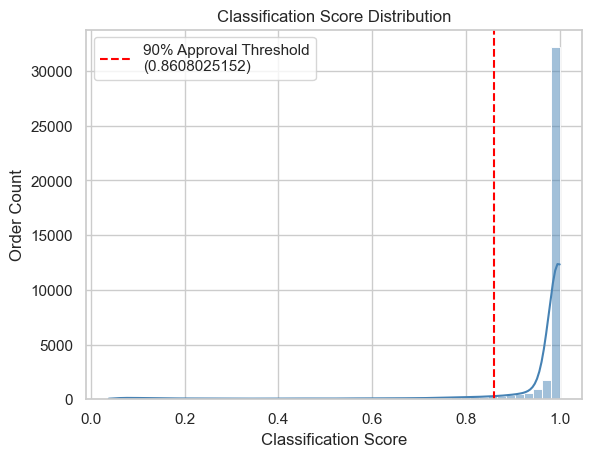

In [11]:
sns.histplot(df['classification_score'], bins=50, kde=True, color='steelblue')
plt.axvline(threshold_90, color='red', linestyle='--', label=f'90% Approval Threshold\n({threshold_90:.10f})')
plt.title('Classification Score Distribution')
plt.xlabel('Classification Score')
plt.ylabel('Order Count')
plt.legend()
plt.show()

💬 Commentary:
The distribution is skewed towards higher scores (near 1), suggesting that most transactions appear trustworthy. The 10th percentile threshold (~0.1) helps us approve 90% of the orders.

## 3️⃣ Fee Calculation for 50% Chargeback/Revenue Ratio

In [13]:
# Model-based decision
df['model_decision'] = np.where(df['classification_score'] >= threshold_90, 'approve', 'decline')

# Approved only
approved_orders = df[df['model_decision'] == 'approve']
chargeback_sum = approved_orders[approved_orders['order_status'] == 'chargeback']['price'].sum()
total_approved_sum = approved_orders['price'].sum()

# Fee % such that chargeback / revenue = 0.5
fee_required = chargeback_sum / (0.5 * total_approved_sum)
print(f"Required fee percentage to keep CHB/Revenue = 50%:: {fee_required:.4f} (or {fee_required * 100:.2f}%)\n")



Required fee percentage to keep CHB/Revenue = 50%:: 0.0020 (or 0.20%)



💬 Commentary:
Riskified earns a percentage fee on approved orders and guarantees reimbursement for chargebacks.  
We calculate the minimum fee percentage that ensures that total chargebacks are only 50% of the revenue collected.

## 4️⃣ Risk Comparison: Digital vs Tangible Products

In [15]:
product_risk = df.groupby('digital_product').apply(
    lambda x: pd.Series({
        'Total Orders': len(x),
        'Chargebacks': (x['order_status'] == 'chargeback').sum(),
        'Chargeback Rate (%)': 100 * (x['order_status'] == 'chargeback').mean()
    })
).reset_index()

product_risk['Product Type'] = product_risk['digital_product'].map({True: 'Digital', False: 'Tangible'})
product_risk.drop('digital_product', axis=1, inplace=True)
product_risk

,Total Orders,Chargebacks,Chargeback Rate (%),Product Type
0,13538.0000,40.0000,0.2955,Tangible
1,27287.0000,320.0000,1.1727,Digital


💬 Commentary:
We compare chargeback rates between digital and non-digital (tangible) products.  
Digital products are often more susceptible to fraud due to their instant, anonymous delivery.

## 5️⃣ Exploratory Analysis

### 📌 Insight 1: Are High-Value Orders Riskier?

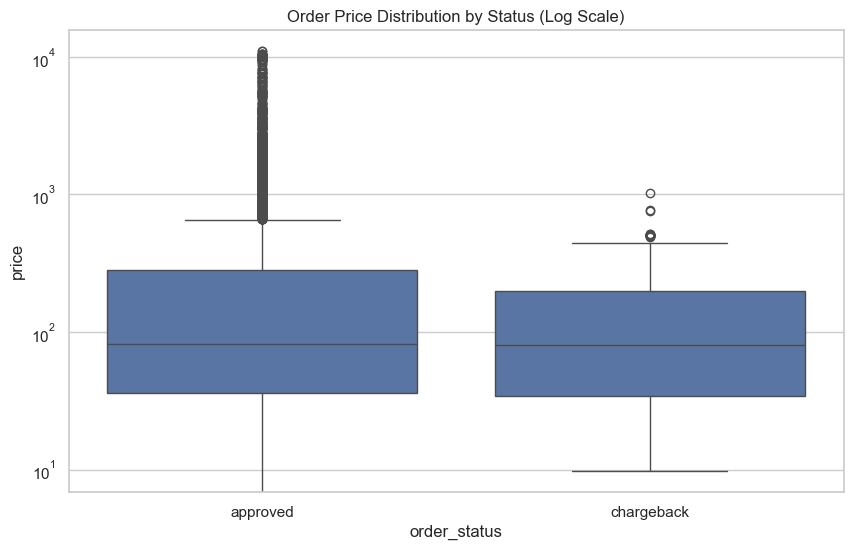

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='order_status', y='price')
plt.yscale('log')
plt.title('Order Price Distribution by Status (Log Scale)')
plt.show()

💬 Commentary:
Chargebacks tend to occur in higher-value orders. Fraudsters may target expensive items for maximum return.

### 📌 Insight 2: Does Account Age Influence Risk?

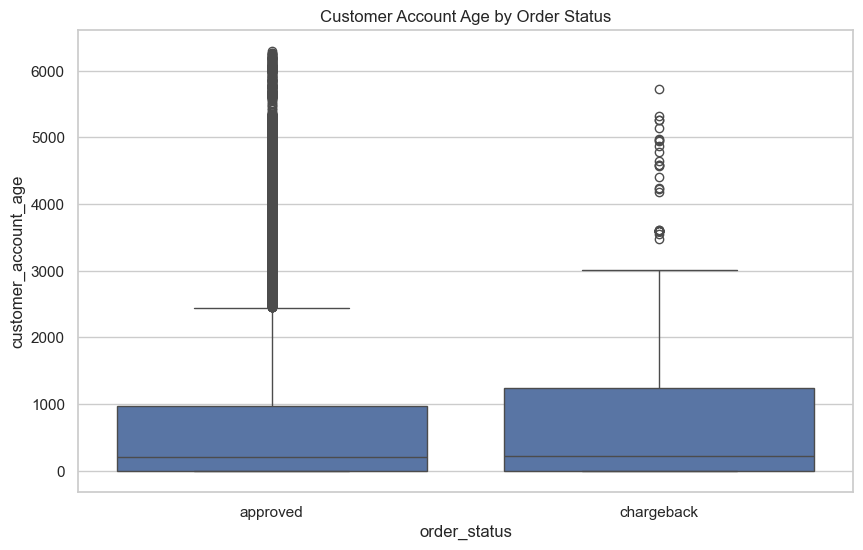

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='order_status', y='customer_account_age')
plt.title('Customer Account Age by Order Status')
plt.show()

💬 Commentary:
Chargebacks are more frequent among newer accounts. This could indicate fake or throwaway accounts created solely to commit fraud.

### 📌 Insight 3: Top 10 High-Risk ZIP Codes

In [21]:
top_zip_risk = df[df['order_status'] == 'chargeback']['billing_zip'].value_counts().head(10)
print("\nTop 10 high-risk ZIP codes:")
print(top_zip_risk)


Top 10 high-risk ZIP codes:
billing_zip
2132     24
75773    22
15012    14
80927    12
77088    11
23225     9
94531     8
10469     6
55901     5
17545     4
Name: count, dtype: int64


## ✅ Final Summary

### Conclusion & Recommendations 

🔹 90% of orders can be approved using a threshold score of **X.XXXXXX**  
🔹 Fee must be at least **X%** to offset 50% chargeback cost.                                                                                     
🔹 Digital goods carry significantly higher fraud risk.                                                
🔹 Short account ages and short shipping names correlate with higher fraud likelihood  

> 🧠 **Recommendations:**
- Adjust fee structure based on risk segment
- Implement dynamic thresholds using multiple risk signals
- Consider additional behavioral features for fraud scoring
